<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'android',
    "board"       : 'juno',
    "host"        : '192.168.1.101',

    # Folder where all the results will be collected
    "results_dir" : "Task_Latencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

05:26:03  INFO    :         Target - Using base path: /data/lisa_fork/lisa
05:26:03  INFO    :         Target - Loading custom (inline) target configuration
05:26:03  INFO    :         Target - External tools using:
05:26:03  INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
05:26:03  INFO    :         Target -    CATAPULT_HOME: /data/lisa_fork/lisa/tools/catapult
05:26:03  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
05:26:03  INFO    :         Target - Connecting Android target [192.168.1.101:5555]
05:26:03  INFO    :         Target - Connection settings:
05:26:03  INFO    :         Target -    {'device': '192.168.1.101:5555'}
05:26:04  INFO    :         Target - Initializing target workdir:
05:26:04  INFO    :         Target -    /data/local/tmp/devlib-target
05:26:10  INFO    :         Target - Topology:
05:26:10  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
05:26:10  INFO    :       Platform - Loading default EM:
05:26

# Workload Execution

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

05:26:12  INFO    :          WlGen - Setup new workload ramp
05:26:12  DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
05:26:12  DEBUG   :          WlGen - Configuring a profile-based workload...
05:26:12  DEBUG   :          RTApp - ref on big cpu: 1
05:26:12  INFO    :          RTApp - Workload duration defined by longest task
05:26:12  INFO    :          RTApp - Default policy: SCHED_OTHER
05:26:12  INFO    :          RTApp - ------------------------
05:26:12  INFO    :          RTApp - task [ramp], sched: using default policy
05:26:12  INFO    :          RTApp -  | calibration CPU: 1
05:26:12  INFO    :          RTApp -  | loops count: 1
05:26:12  INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
05:26:12  INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
05:26:12  INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
05:26:12  INFO    :          RTApp - + phase_000002: duration 0.50000

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

05:26:23  INFO    : Content of the output folder /data/lisa_fork/lisa/results/Task_Latencies


/data/lisa_fork/lisa/results/Task_Latencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-0.log
├── rt-app-ramp_1-1.log
├── rt-app-ramp_2-2.log
├── task_latencies_1552_1552__ramp,_rt-app.png
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 11 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

05:26:23  INFO    : LITTLE cluster max capacity: 447


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

05:26:23  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/Task_Latencies/trace.dat]...
05:26:23  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_load_avg_cpu', 'sched_load_avg_task']
05:26:23  INFO    : Parsing FTrace format...
05:26:23  DEBUG   : Events found on trace:
05:26:23  DEBUG   :  - sched_load_avg_cpu
05:26:23  DEBUG   :  - sched_load_avg_task
05:26:23  DEBUG   :  - sched_switch
05:26:23  DEBUG   :  - sched_wakeup
05:26:23  DEBUG   : Lookup dataset for tasks...
05:26:23  INFO    : Collected events spans a 5.350 [s] time interval
05:26:23  INFO    : Set plots time range to (0.000000, 5.350288)[s]
05:26:23  DEBUG   : Registering [<trace.Trace object at 0x7fd9fc028690>] local data frames
05:26:23  DEBUG   :    functions_stats
05:26:23  DEBUG   :    trace_event
05:26:23  DEBUG   :       Analysis - Analysis: /data/lisa_fork/lisa/libs/utils/analysis
05:26:23  DEBUG   :       Analysis - Syspath: ['/data/lisa_fork/lisa/libs/utils/analysi

# Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [11]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.228968,NaN,0.0,A,R,0.228968,0.185253
0.414221,NaN,0.0,R,A,0.414221,0.000122
0.414343,NaN,2.0,A,S,0.414343,0.108478
0.522821,NaN,2.0,S,W,0.522821,0.006381
0.529202,2.0,NaN,W,A,0.529202,0.000017


In [12]:
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000006,<idle>,2,0,shell srvc 1534,1535,120,swapper/2,0,120,0
0.000118,shell,2,1535,swapper/2,0,120,shell srvc 1534,1535,120,1
0.000197,<idle>,1,0,adbd,174,120,swapper/1,0,120,0
0.000246,trace-cmd,3,1538,swapper/3,0,120,trace-cmd,1538,120,64
0.000367,<idle>,2,0,sh,1537,120,swapper/2,0,120,0


In [13]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
0.375050,0.000010
0.475102,0.000021
0.575101,0.000020
0.675103,0.000021
0.775102,0.000021


In [14]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
0.289829,0.000559
0.313554,0.000051
0.315149,0.000008
0.315197,0.000010
1.001528,0.000059


## Latency Plots

01:18:36  INFO    : Found:    45 WAKEUP latencies
01:18:36  INFO    : Found:   100 PREEMPT latencies
01:18:36  INFO    : Total:   145 latency events
01:18:37  WARNING : Event [sched_overutilized] not found, plot DISABLED!


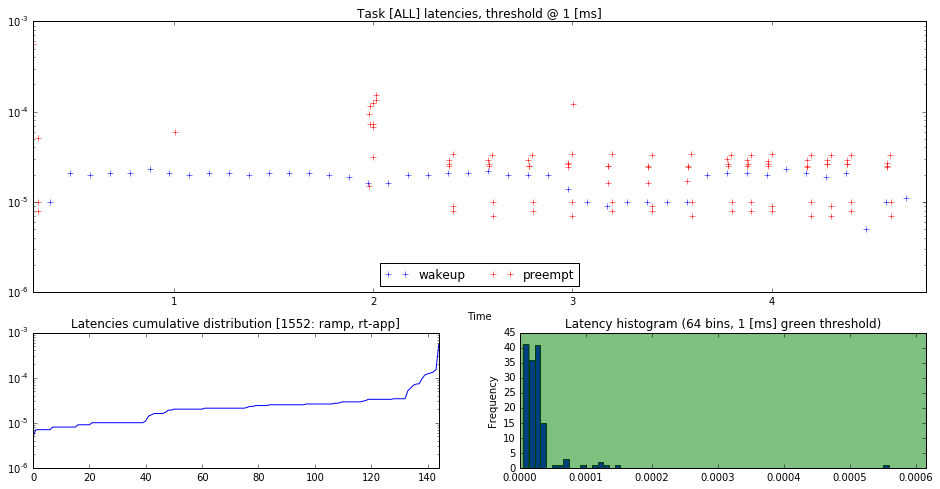

In [15]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [16]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max
latency,145.0,0.000029,0.00005,0.000005,0.000021,0.000073,0.000143,0.000559


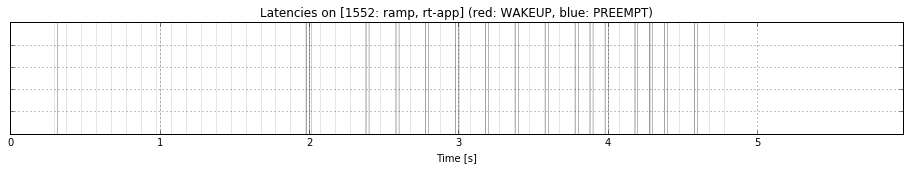

In [17]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

01:19:49  INFO    : Set plots time range to (2.970000, 3.020000)[s]


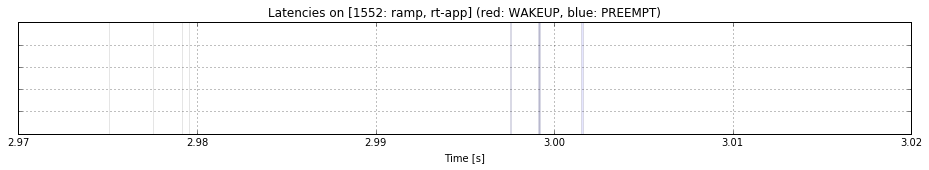

In [20]:
# Zoom into a spefific time frame
#trace.setXTimeRange(3.445, 3.45)
trace.setXTimeRange(2.97, 3.02)
trace.analysis.latency.plotLatencyBands('ramp')